<a href="https://colab.research.google.com/github/BBulMushroom/CIFAR_10_classification/blob/ResNet9/CNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<link href="http://github.com/yrgoldteeth/darkdowncss/raw/master/darkdown.css" rel="stylesheet"></link>

In [42]:
!nvidia-smi

Mon Nov 22 13:21:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    42W / 250W |   6765MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Cifar10 image classification**
******************************************
**점수관련**  
본 프로젝트는 Accuracy 점수와 보고서를 성적에 반영할 예정입니다. 평가 항목은 아래와 같습니다. 

A. 결과 (40%)
- Metric 성능 :(이미지 분류 - Accuracy)

B. 신규성 (30%)
- Network 변경 내용 - **필수**
- 성능 개선 및 overfitting 방지 시도 (ex. train validation split)

C. 이론적 근거 (20%)
- 기존 baseline과의 차별점 
- 성능 개선을 위한 시도와 이유

D. 보고서 완성도 (10%)

******************************************
**보고서**
1. 연구 목적
2. 모델 구조
3. 실험 내용
4. 실험 결과
5. 고찰 및 결론
6. Colab 파일 (동작 가능여부)

제출하실 파일은 **주피터 노트북 파일**('.ipynb',파일>다운로드)과 **결과 보고서**(pdf)입니다.
******************************************
**코드 검증**  
- 코드 성능 평가(metric)는 torchvision.datasets에 있는 cifar10의 testset을 사용해 Accuracy로 평가합니다.
- pretrain 모델 사용 불가능합니다.

또한 Random 라이브러리 사용시에 seed 고정하는 등 재현을 고려하시고 코딩부탁드립니다. 
******************************************
**GPU 사용 법**  
런타임 > 런타임 유형 변경 > 하드웨어 가속기에서 GPU를 선택하면 GPU를 사용 할 수 있습니다.  
******************************************
**Colab 사용시 유의사항**  
12시간 단위로 가상머신을 사용할 수 있고 12시간이 지나면 모든 파일과 작업로그들이 초기화 됩니다. 또한, 12시간 넘게 GPU를 사용하기는 어려우니 일찍 시작하셔서 틈틈히 실험해보시는 것을 추천드립니다.


******************************************
**Q?**

#평균, 분산

```
original_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
data = original_trainset.data / 255
mean = data.mean(axis = (0,1,2))
std = data.std(axis = (0,1,2))
print(f"Trainset -> Mean : {mean}   STD: {std}")

original_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
data = original_testset.data / 255
mean = data.mean(axis = (0,1,2))
std = data.std(axis = (0,1,2))
print(f"Testset  -> Mean : {mean}   STD: {std}")
```

Files already downloaded and verified

Trainset -> Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]

Files already downloaded and verified

Testset  -> Mean : [0.49421428 0.48513139 0.45040909]   STD: [0.24665252 0.24289226 0.26159238]

In [43]:
# Training

import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from google.colab import drive
import time
from collections import defaultdict
from tabulate import tabulate
from IPython.display import clear_output

drive.mount('/content/gdrive')
PATH = '/content/gdrive/Shareddrives/전자공학종합설계/ResNet9//model_ckpt.pt'

# 하이퍼 파라미터
EPOCH = 100
batch_size = 500
learning_rate = 0.001
grad_clip = 0.1
weight_decay = 0.0001

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

# 분류 Class list
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# 이미지 전처리
torch.manual_seed(600)  # 시드 고정
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomCrop(32, padding=4, padding_mode = 'reflect'),
     transforms.RandomHorizontalFlip(),
     transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784), inplace=True)
     #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010), inplace=True)
     ])
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.49421428, 0.48513139, 0.45040909), (0.24665252, 0.24289226, 0.26159238), inplace=True)
     #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010), inplace=True)
     ])

# Dataset. 변경 불가
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=2, pin_memory=True)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
cuda:0 is available
Files already downloaded and verified
Files already downloaded and verified


In [44]:
# ResNet9
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class Net(nn.Module):
  def __init__(self):
    super().__init__()
        
    self.conv1 = conv_block(3, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
    
    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
    
    self.classifier = nn.Sequential(nn.MaxPool2d(4), nn.Flatten(), nn.Linear(512, 10))
        
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out

In [45]:
# Network 선언
net = Net().to(device)

# criterion. 변경 '가능'
criterion = nn.CrossEntropyLoss()

# Optimizer
#optimizer = optim.RMSprop(net.parameters(), lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate, amsgrad=True)

# Scheduler
#scheduler = optim.lr_scheduler.([0, 5, epochs], [0, 0.4, 0])
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=10, factor=0.9, verbose=True)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr = 0.01, epochs=EPOCH, steps_per_epoch=len(trainloader))
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)


# Training
acc = 0
last_acc = 0
n = len(trainloader)
result = defaultdict(list, {'Epoch': [], 'Working Time': [], 'Loss': [], 'Last lr': [], 'Accuracy': []}) # 출력 데이터

for epoch in range(EPOCH): 

  running_loss = 0.0
  start = time.time()
  for data in tqdm(trainloader):
    
    inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터

    outputs = net(inputs)
    loss = criterion(outputs, labels) # 크로스 엔트로피 손실함수 계산 

    loss.backward() # backpropagation

    optimizer.step() # 가중치 최적화
    optimizer.zero_grad() # 배치마다 optimizer 초기화

    running_loss += loss.item()
    scheduler.step()
  end = time.time()

  # Validation
  correct = 0
  total = 0
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for data in testloader:
      images, labels = data[0].to(device), data[1].to(device)
      # calculate outputs by running images through the network
      outputs = net(images)
      # the class with the highest energy is what we choose as prediction
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      # collect the correct predictions for each class
      for label, prediction in zip(labels, predicted):
        if label == prediction:
          correct_pred[classes[label]] += 1
          total_pred[classes[label]] += 1
  
  acc = 100 * correct / total
  print('Epoch: %d, Loss: %.3f, Last lr: %.5f, Accuracy: %.2f%%' %(epoch + 1, 
                                                              running_loss / len(trainloader), 
                                                              optimizer.param_groups[0]['lr'], 
                                                              acc))

  result['Epoch'].append(epoch+1)
  result['Working Time'].append(end-start)
  result['Loss'].append(format(running_loss / len(trainloader), '.3f'))
  result['Last lr'].append(format(optimizer.param_groups[0]['lr'], '.5f'))
  result['Accuracy'].append(format(acc, '.2f'))

  if acc > last_acc:
    torch.save(net.state_dict() , PATH) # 모델 저장, path 수정
    print('Checkpoint Saved!')
    last_acc = acc

clear_output()  # 화면 clear
print(tabulate(result, headers='keys', tablefmt="fancy_grid"))  # 결과표 출력

╒═════════╤════════════════╤════════╤═══════════╤════════════╕
│   Epoch │   Working Time │   Loss │   Last lr │   Accuracy │
╞═════════╪════════════════╪════════╪═══════════╪════════════╡
│       1 │        17.3964 │  1.361 │   0.00043 │      65.2  │
├─────────┼────────────────┼────────┼───────────┼────────────┤
│       2 │        17.7137 │  0.903 │   0.0005  │      74.65 │
├─────────┼────────────────┼────────┼───────────┼────────────┤
│       3 │        17.4814 │  0.705 │   0.00064 │      78.61 │
├─────────┼────────────────┼────────┼───────────┼────────────┤
│       4 │        17.543  │  0.585 │   0.00082 │      81.33 │
├─────────┼────────────────┼────────┼───────────┼────────────┤
│       5 │        17.4173 │  0.512 │   0.00104 │      83.09 │
├─────────┼────────────────┼────────┼───────────┼────────────┤
│       6 │        17.4951 │  0.47  │   0.00132 │      83.86 │
├─────────┼────────────────┼────────┼───────────┼────────────┤
│       7 │        17.4611 │  0.42  │   0.00163 │      

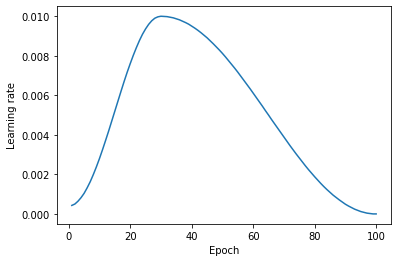

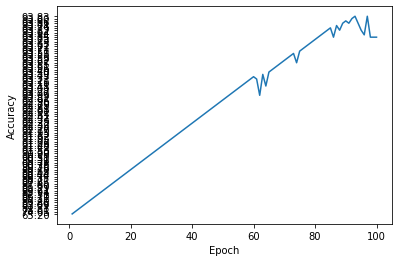

In [46]:
# plot

# learning rate
ax1 = plt.subplot(3, 1, 1)
plt.plot(result['Epoch'], list(map(float, result['Last lr'])))
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.show()

# accuracy
ax2 = plt.subplot(3, 1, 2, sharex = ax1)
plt.plot(result['Epoch'], list(map(float, result['Accuracy'])))
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

# Loss
ax3 = plt.subplot(3, 1, 3, sharex = ax1)
plt.plot(result['Epoch'], list(map(float, result['Loss'])))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluation

In [47]:
# Evaluation

# 수정
net = Net()
net.to(device)
net.load_state_dict(torch.load(PATH)) # 저장된 모델 불러오기

# 이하 전체 수정 불가
correct = 0
total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    100. * correct / total))

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy of the network on the 10000 test images: 93.94 %
Accuracy for class plane is: 94.4 %
Accuracy for class car   is: 97.7 %
Accuracy for class bird  is: 90.2 %
Accuracy for class cat   is: 88.0 %
Accuracy for class deer  is: 95.8 %
Accuracy for class dog   is: 89.4 %
Accuracy for class frog  is: 95.5 %
Accuracy for class horse is: 96.8 %
Accuracy for class ship  is: 96.1 %
Accuracy for class truck is: 95.5 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


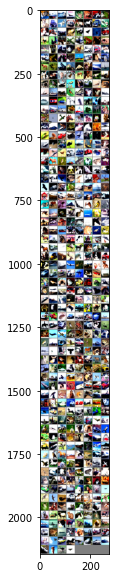

GrouTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  bird  deer   car truck   dog  deer  frog   dog  frog plane truck   cat truck horse  frog
Predicted:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog  deer   dog truck  ship  deer   car truck   dog  deer  frog   dog  frog plane truck   cat  ship horse  frog


In [48]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
data = dataiter.next()
images, labels = data

# print images
imshow(torchvision.utils.make_grid(images))
print('GrouTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(50)))

net.load_state_dict(torch.load(PATH))

images, labels = data[0].to(device), data[1].to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(50)))